In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [6]:
#path to our cropped images
dataset_path = 'archive/crop/'

#splitting into training and validation
train_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.3,
    seed = 23,
    subset = 'training',
    image_size=(128, 128),  # Adjust the image size to 128 x 128 for faster processing
    batch_size=32,          # How many samples we want to load / batch
    shuffle=True            
)

valid_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.3,
    seed = 23,
    subset = 'validation',
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

# Split validation_data into validation & test set
val_batches = tf.data.experimental.cardinality(valid_data) # takes the number of batches within the validation data
test_data = valid_data.take(val_batches // 4) # takes the 
val_data = valid_data.skip(val_batches // 4)

class_names = train_data.class_names

Found 31586 files belonging to 73 classes.
Using 22111 files for training.
Found 31586 files belonging to 73 classes.
Using 9475 files for validation.


2024-11-04 00:04:32.011569: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


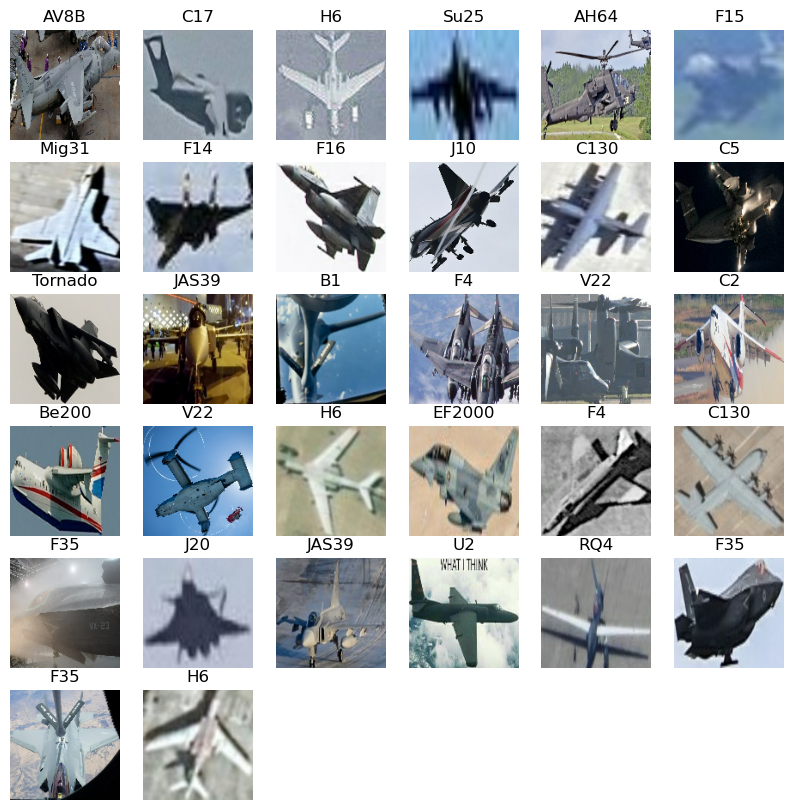

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(32, len(images))):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
# allows the model to load the next batch while the model is training on the current batch, increasing efficiency
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)

# allows the model generalize better by exposing it to variations that it may encounter in real-life data, reducing overfitting
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

preprocess_input = preprocess_input

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# uses weights from ImageNet dataset, which has patterns that are useful for image classification
# excludes the final dense layers that was specifically trained for ImageNet, instead adapting the model for our custom dataset
base_model.trainable = False
# Freezes the layers which retains the high-level features learned from ImageNet and focuses only on training the new layers added on ResNet50
base_model.summary()

global_avg = layers.GlobalAveragePooling2D()
# Reduces the spatial dimensions of the feature map from the ResNet50 output, computing the avg value of the feature map. 
# Drastically reduces the # of parameters, decreasing risk of overfitting while retaining important info of the image
output_layer = layers.Dense(len(class_names), activation='softmax')

inputs = tf.keras.Input(shape = (128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128, 128)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128, 128)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128, 128)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 128, 128,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 73)        │    149,577 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,737,289 (90.55 MB)

 Trainable params: 149,577 (584.29 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

history = model.fit(pf_train, validation_data=(pf_val), epochs = 5)


Epoch 1/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 229s 328ms/step - accuracy: 0.2268 - loss: 3.6825 - val_accuracy: 0.4166 - val_loss: 2.4947
Epoch 2/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 221s 319ms/step - accuracy: 0.5145 - loss: 1.8531 - val_accuracy: 0.4534 - val_loss: 2.3364
Epoch 3/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 224s 324ms/step - accuracy: 0.6252 - loss: 1.3524 - val_accuracy: 0.4954 - val_loss: 2.2144
Epoch 4/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 222s 321ms/step - accuracy: 0.6939 - loss: 1.0810 - val_accuracy: 0.5106 - val_loss: 2.1656
Epoch 5/5
691/691 ━━━━━━━━━━━━━━━━━━━━ 229s 332ms/step - accuracy: 0.7479 - loss: 0.8760 - val_accuracy: 0.5220 - val_loss: 2.1818


2024-11-04 00:25:57.347987: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


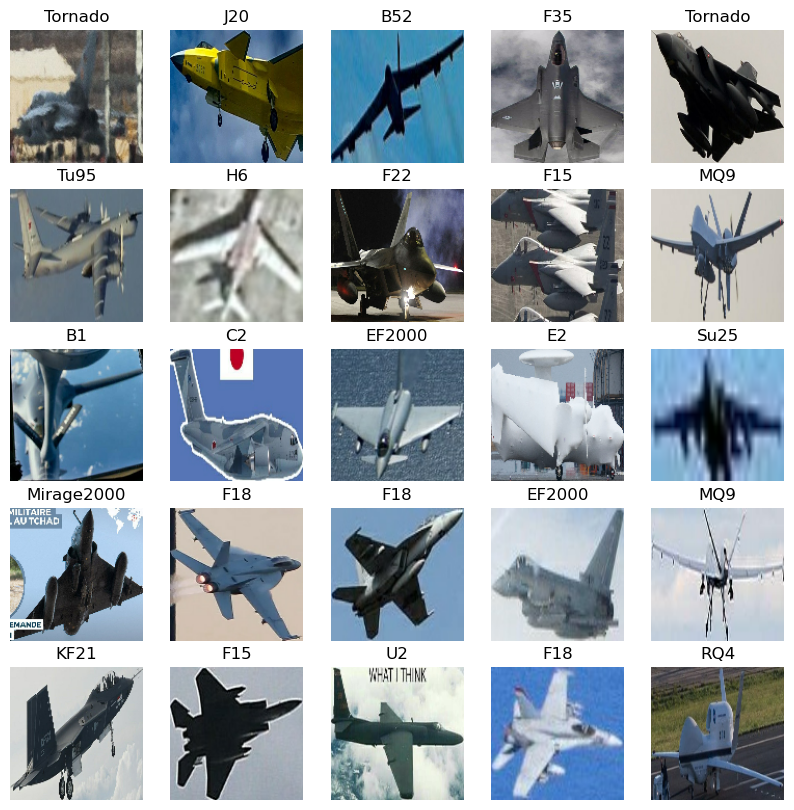

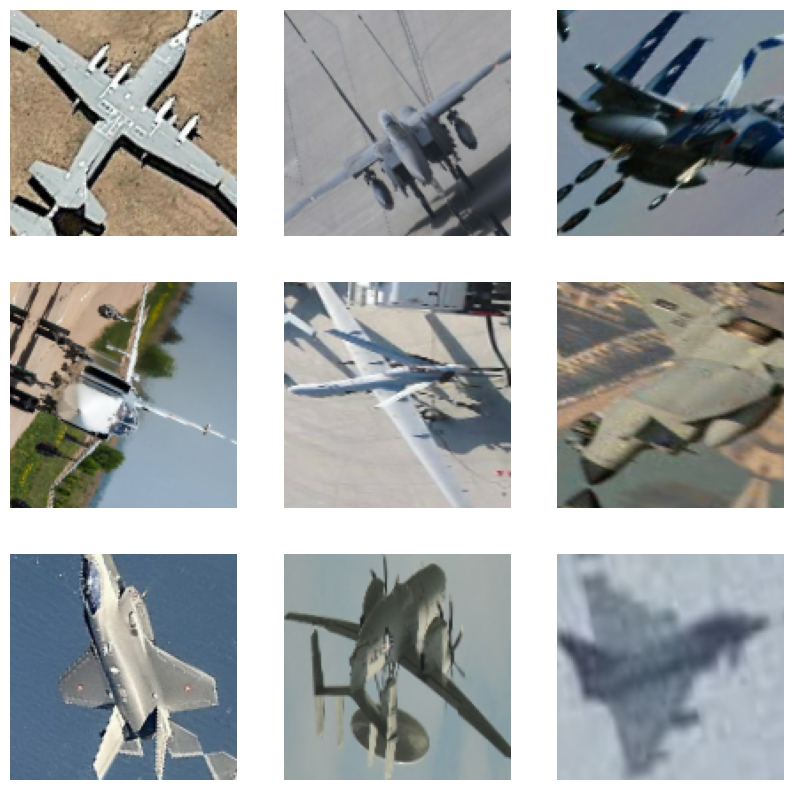

You must install pydot (`pip install pydot`) for `plot_model` to work.


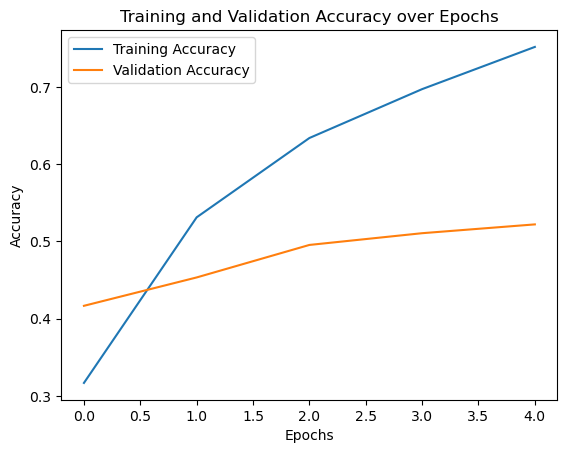

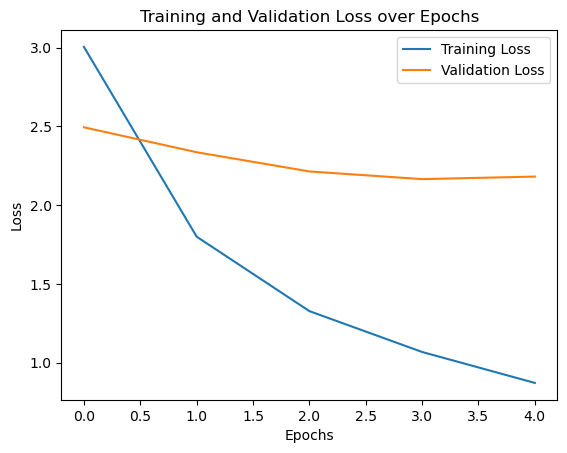

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(25, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(images[i], axis=0))
        augmented_image = tf.squeeze(augmented_image, axis=0)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.axis("off")
plt.show()

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()